In [1]:
import torch
import torch.nn as nn
import gym
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
class ActorCritic(nn.Module):
    def __init__(self, input_dim, num_actions, hidden_size):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions

        self.critic = nn.Sequential(nn.Linear(input_dim, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, 1))

        self.actor = nn.Sequential(nn.Linear(input_dim, hidden_size), nn.Tanh(), 
            nn.Linear(hidden_size, num_actions))

    def forward(self, observation):
        value = self.critic(observation)
        d = 1
        if len(observation.size()) == 1:
            d = 0
        policy_s = nn.functional.softmax(self.actor(observation), dim=d)

        return value, policy_s

In [3]:
env = gym.make('CartPole-v1')
outdir = 'TME5/cartpole-v0/DQN-agent-results'
envm = gym.wrappers.Monitor(env, directory=outdir, force=True, video_callable=False)
env.seed(0)
env.verbose = False

/home/raouf/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
NUM_EPISODES = 5000
NUM_STEPS = 500
GAMMA = 0.999

learning_rate = 0.0005

hidden_layer_size = 128

input_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

actor_critic = ActorCritic(input_dim, action_dim, hidden_layer_size)
optimizer = torch.optim.Adam(actor_critic.parameters(), lr=learning_rate)

ls = []

start = time.time()

for episode in range(NUM_EPISODES):
    logprobs = []
    values = []
    rewards = []
    
    state = env.reset()

    start_episode = time.time()
    for steps in range(NUM_STEPS):
        value, policy = actor_critic.forward(torch.from_numpy(state).float())
        value = value.detach().numpy()[0]
        policy_detach = policy.detach().numpy() 

        chosen_action = np.random.choice(action_dim, p=policy_detach)
        log_prob = torch.log(policy.squeeze(0)[chosen_action])
        

        new_state, reward, done, _ = env.step(chosen_action)
        
        rewards.append(reward)
        values.append(value)
        logprobs.append(log_prob)
        state = new_state
        
        if done or steps == NUM_STEPS-1:
            Qval, _ = actor_critic.forward(torch.from_numpy(new_state).float())
            Qval = Qval.detach().numpy()[0]
            
            ls.append(steps)
            break

    # compute Q values
    Qvals = np.zeros_like(values)
    for t in reversed(range(len(rewards))):
        Qval = rewards[t] + GAMMA * Qval 
        Qvals[t] = Qval
        
    values = torch.FloatTensor(values)
    Qvals = torch.FloatTensor(Qvals)
    logprobs = torch.stack(logprobs)
        
    advantage = Qvals - values
    
    

    actor_loss = (-logprobs * advantage).mean()

    critic_loss = advantage.pow(2).mean()
        
    ac_loss = actor_loss + critic_loss

    optimizer.zero_grad()
    ac_loss.backward()
    optimizer.step()
    
    if episode % 10 == 0:
        print("episode {}".format(episode)+" reward: ", np.sum(rewards))


episode 0 reward:  27.0
episode 10 reward:  22.0
episode 20 reward:  12.0
episode 30 reward:  23.0
episode 40 reward:  22.0
episode 50 reward:  39.0
episode 60 reward:  75.0
episode 70 reward:  10.0
episode 80 reward:  22.0
episode 90 reward:  18.0
episode 100 reward:  16.0
episode 110 reward:  58.0
episode 120 reward:  50.0
episode 130 reward:  27.0
episode 140 reward:  57.0
episode 150 reward:  29.0
episode 160 reward:  17.0
episode 170 reward:  53.0
episode 180 reward:  27.0
episode 190 reward:  21.0
episode 200 reward:  47.0
episode 210 reward:  18.0
episode 220 reward:  44.0
episode 230 reward:  54.0
episode 240 reward:  36.0
episode 250 reward:  56.0
episode 260 reward:  45.0
episode 270 reward:  26.0
episode 280 reward:  63.0
episode 290 reward:  44.0
episode 300 reward:  25.0
episode 310 reward:  33.0
episode 320 reward:  47.0
episode 330 reward:  99.0
episode 340 reward:  69.0
episode 350 reward:  38.0
episode 360 reward:  95.0
episode 370 reward:  29.0
episode 380 reward:  10

episode 2990 reward:  233.0
episode 3000 reward:  500.0
episode 3010 reward:  500.0
episode 3020 reward:  500.0
episode 3030 reward:  500.0
episode 3040 reward:  500.0
episode 3050 reward:  500.0
episode 3060 reward:  500.0
episode 3070 reward:  500.0
episode 3080 reward:  500.0
episode 3090 reward:  500.0
episode 3100 reward:  500.0
episode 3110 reward:  500.0
episode 3120 reward:  500.0
episode 3130 reward:  500.0
episode 3140 reward:  500.0
episode 3150 reward:  500.0
episode 3160 reward:  500.0
episode 3170 reward:  500.0
episode 3180 reward:  500.0
episode 3190 reward:  500.0
episode 3200 reward:  500.0
episode 3210 reward:  500.0
episode 3220 reward:  500.0
episode 3230 reward:  500.0
episode 3240 reward:  500.0
episode 3250 reward:  500.0
episode 3260 reward:  500.0
episode 3270 reward:  500.0
episode 3280 reward:  500.0
episode 3290 reward:  500.0
episode 3300 reward:  500.0
episode 3310 reward:  500.0
episode 3320 reward:  500.0
episode 3330 reward:  500.0
episode 3340 reward:

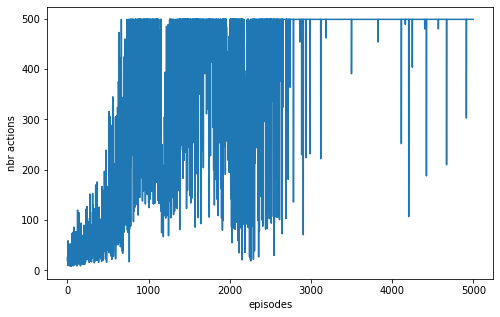

In [5]:

%matplotlib inline

smoothed_rewards = pd.Series.rolling(pd.Series(ls), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]

plt.figure(figsize=(8, 5))
plt.plot(ls)
plt.plot(smoothed_rewards,"r")
plt.xlabel("episodes")
plt.ylabel("nbr actions")
plt.show()

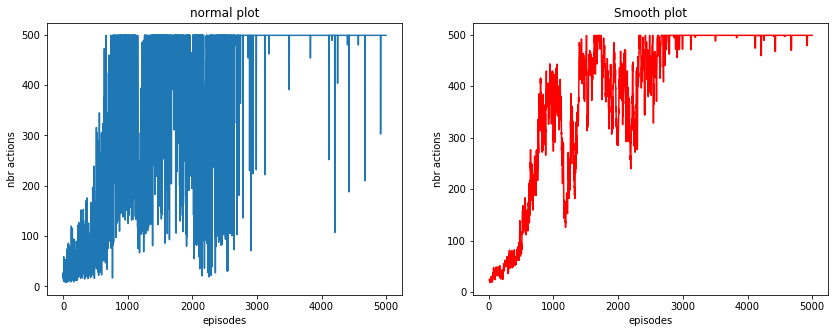

In [12]:
%matplotlib inline

import pandas as pd 

smoothed_rewards = pd.Series.rolling(pd.Series(ls), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]


plt.figure(figsize=(14, 5))

plt.subplot(1,2,1)
plt.plot(ls)
plt.title("normal plot")
plt.xlabel("episodes")
plt.ylabel("nbr actions")

plt.subplot(1,2,2)
plt.plot(smoothed_rewards ,"r")
plt.title("Smooth plot")
plt.xlabel("episodes")
plt.ylabel("nbr actions")

plt.show()